In [1]:
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import numpy as np
import numpy.matlib as matlib
import glob
import calendar
import pymannkendall as mk
import regionmask
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
# Seasonal definitions of May-October Growing Season and bi-monthly periods
def is_GS(month):
    return (month >= 5) & (month <= 10)

def is_JA(month):
    return (month >= 7) & (month <= 8)

In [3]:
# Create precip mask to use on PDSI
## Calculations on observational data 
fname1 = '/glade/work/tanderson/GPCC/gpcc_05_v2020.nc'

#Load GPCC obs
dset_obsP = xr.open_mfdataset(fname1)
dset_obsP = dset_obsP.sel(lat=slice(18,11), lon=slice(-93,-83), time=slice('1920-01-01','2019-12-01')) # slice data to lat and lons of interest

# Set units and get time
dset_obsP.attrs['units'] = 'mm/month'
dset_obs_yearP = dset_obsP['time.year']
dset_obs_monthP = dset_obsP['time.month']

# Make a regional mask
landP = regionmask.defined_regions.natural_earth_v5_0_0.land_10.mask(dset_obsP)

# Precip Masked
obsLandP = dset_obsP.where(landP==0)

 # Get annual precip total 
annObsP = obsLandP.groupby('time.year').sum('time', skipna=False, keep_attrs=True) 
    
# Get annual GS total
GSObsP = obsLandP.sel(time=is_GS(obsLandP['time.month']))
GSObsP = GSObsP.groupby('time.year').sum('time', skipna=False,keep_attrs=True) 

# Calculate % of annual rainfall in GS
GSpercObsP = np.divide(GSObsP,annObsP)*100
    
# Get average annual % of rainfall
avgGSpercObsPrecip = GSpercObsP.mean('year', keep_attrs=True)


In [9]:
## Calculations on observational PDSI data 
fname = '/glade/work/tanderson/CRU_PDSI/scPDSI.cru_ts4.06early1.1901.2021.cal_1950_21.bams.2022.GLOBAL.IGBP.WHC.1901.2021.nc'

#Load GPCC obs
dset_obs = xr.open_mfdataset(fname)
dset_obs = dset_obs.sel(latitude=slice(18,11), longitude=slice(-93,-83), time=slice('1940-01-01','2019-12-01')) # slice data to lat and lons of interest

# Have to rename to be able to mask with precip
dset_obs = dset_obs.rename({'latitude': 'lat','longitude': 'lon','scpdsi':'precip'})
dset_obs = dset_obs.where(dset_obs.precip!=-9999.0)

# Get time
dset_obs_year = dset_obs['time.year']
dset_obs_month = dset_obs['time.month']

# Make a regional mask
land = regionmask.defined_regions.natural_earth_v5_0_0.land_10.mask(dset_obs)

# Precip Masked
obsLand = dset_obs.where(land==0)
#obsLand.precip[1].plot()
    
# Get annual GS mean PDSI
GSObs = obsLand.sel(time=is_GS(obsLand['time.month']))
GSObs = GSObs.groupby('time.year').mean('time', skipna=False,keep_attrs=True) 
     
# Get mean seasonal PDSI 
meanGSObs = GSObs.mean('year', keep_attrs=True)
    
# Mask PDSI where annual growing season precip <75% of annual
GSanomPObs = GSObs.where(avgGSpercObsPrecip>75)

#Take regional mean
regTS_GSObs = GSanomPObs.mean(['lat','lon'])
    
# Get 5 year moving mean for region
reg5mov_GSObs = regTS_GSObs.rolling(year=5).mean()

In [10]:
# Get 2015-2019 obs 5 year means
print(reg5mov_GSObs.precip.values[-1])
print(reg5mov_JAObs.precip.values[-1])

-1.542842490842491
-1.6822857142857146


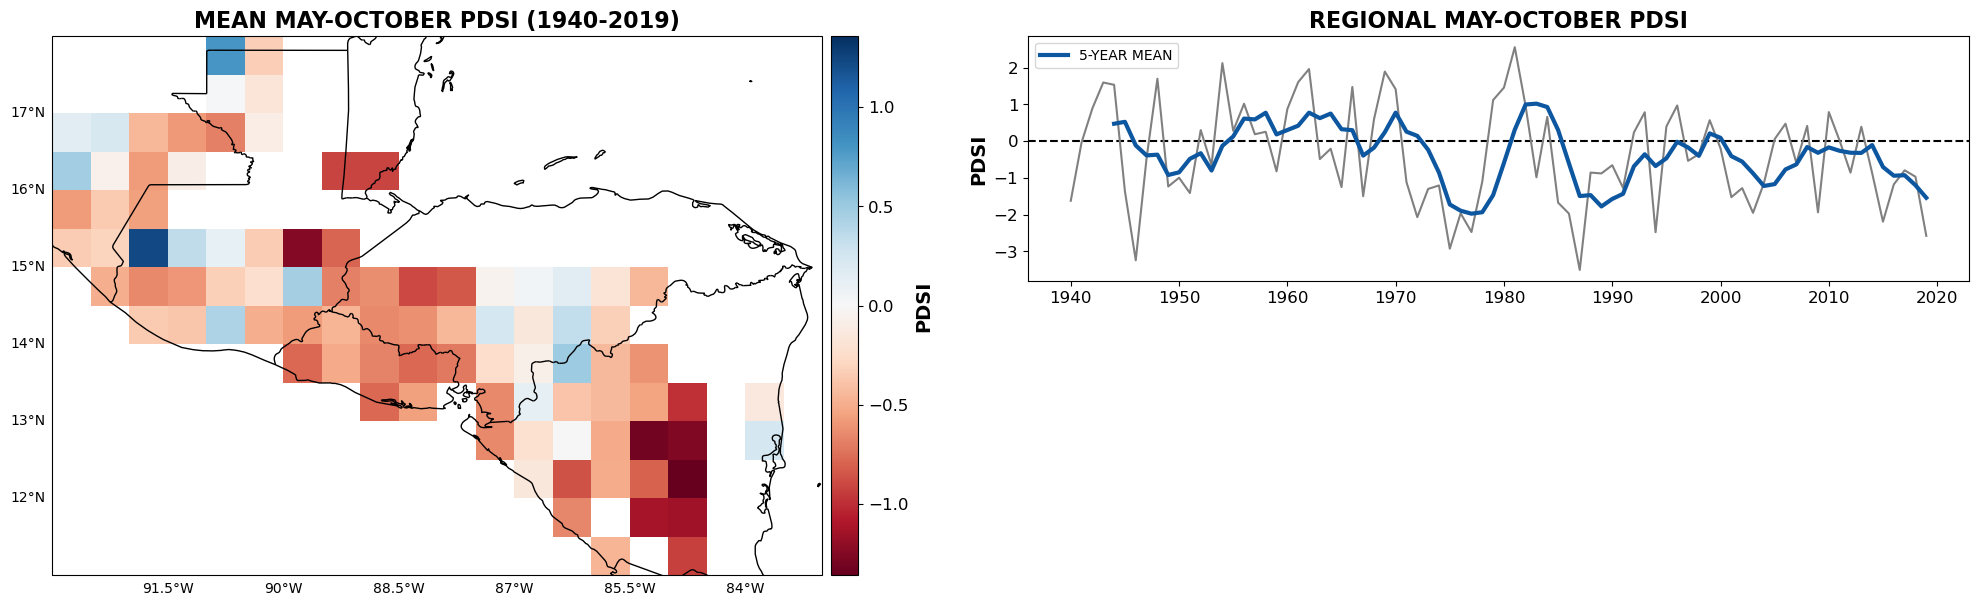

In [12]:
# Plot Study Area and May-Oct time series
meanPlt = meanGSObs.where(avgGSpercObsPrecip>75)

#Blue color
cmap = mpl.colormaps['Blues']
blu = cmap(.85)

fig = plt.figure(figsize=[25,7])
#gs = gridspec.GridSpec(5,20, figure=fig)

ax1 = plt.subplot2grid((2,6),(0,0),rowspan = 2, colspan=3, projection=ccrs.PlateCarree(central_longitude = 0.0))
plt1 = meanPlt.precip.plot(ax=ax1, extend='max', cmap='RdBu',
                    transform=ccrs.PlateCarree(), add_colorbar = False)
cb = plt.colorbar(plt1, orientation="vertical", pad=0.01)
cb.set_label(label='PDSI', weight='bold',fontsize=14)
cb.ax.tick_params(labelsize=12)
ax1.coastlines()
ax1.add_feature(cf.BORDERS)
#ax.add_feature(cf.OCEAN, facecolor='white', zorder=100, edgecolor='k')
ax1.set_title(f'MEAN MAY-OCTOBER PDSI (1940-2019)', fontweight = 'bold', fontsize=16)
gl = ax1.gridlines(draw_labels=True)
gl.xlines = False
gl.ylines = False
gl.top_labels = False
gl.right_labels = False

ax2 = plt.subplot2grid((2,6),(0,3),rowspan = 1, colspan=3)
plt.axhline(0,color = 'black', linestyle = '--')
ax2.plot(regTS_GSObs.year, regTS_GSObs.precip,color="grey")
yr5lineGS, = ax2.plot(reg5mov_GSObs.year, reg5mov_GSObs.precip,color=blu,linewidth=3.0, label="5-YEAR MEAN")
ax2.legend(handles=[yr5lineGS], loc='upper left')
ax2.set_ylabel(f'PDSI',fontweight = 'bold', fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_title(f'REGIONAL MAY-OCTOBER PDSI', fontweight = 'bold', fontsize=16)

plt.show()
#fig.savefig('/Users/taliaanderson/PROJECTS/HEGS_SES_Guate/DC_Drought/Figures/DroughtMapAndTS_PDSI.eps', format='eps')


In [15]:
# OLENS ANALYSIS

# Set up empty arrays
n_ens_mems = 1000
memTS_GS = np.empty((80, n_ens_mems))
memTS_GS_5yr = np.empty((80, n_ens_mems))

fnames = sorted(glob.glob('/glade/scratch/tanderson/obsLE/output_v-CRU_pdsiOrig_wF_CMIP6_CentAm_02/obs/pdsi/pdsi_member????.nc'))
dset_pre = xr.open_mfdataset(fnames[1]).load()
dset_pre = dset_pre.sel(lat=slice(18,11), lon=slice(-93,-83)) # slice data to lat and lons of interest

# Get time 
dset_year = dset_pre['time.year']
dset_month = dset_pre['time.month']

# Make a regional mask
landOle = regionmask.defined_regions.natural_earth_v5_0_0.land_10.mask(dset_pre)

# Precip Masked
oleLand = dset_pre.where(landOle==0)

for i in np.arange(0,len(fnames)):
    dset = xr.open_dataset(fnames[i]).load()
    pdsi = dset.pdsi
    pdsiLand = pdsi.where(landOle==0)
    pdsiLandMask = pdsiLand.where(avgGSpercObsPrecip>75) # mask with same as obs

    memMon = pdsiLandMask.as_numpy()
    
    # Get annual GS total
    GS = memMon.sel(time=is_GS(memMon['time.month']))
    GS = GS.groupby('time.year').mean('time', skipna=False, keep_attrs=False) 
    
    #Take regional mean
    regTS_GS = GS.mean(['lat','lon'])
    
    # Get 5 year moving mean for region
    reg5mov_GS = regTS_GS.rolling(year=5).mean()

    # Add to empty array
    memTS_GS_5yr[:,i] = reg5mov_GS.to_array()
    
    ## For trends
    # Take regional mean
    memTS_GS[:,i] = regTS_GS.to_array()
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [16]:
# Calculate obs trend in PDSI
# Mask
GSmaskTr = GSObs.where(avgGSpercObsPrecip>75)

# Subset to the last 40 years
GSmaskTr = GSmaskTr.sel(year=slice(1980,2019))

# Take regional mean
regTr_GS = GSmaskTr.mean(['lat','lon'])

# Get trend
mkGSout = mk.original_test(regTr_GS.precip.values, alpha=0.05)
print(mkGSout)

Mann_Kendall_Test(trend='no trend', h=False, p=0.16560248483061546, z=-1.3864731127244019, Tau=-0.15384615384615385, s=-120.0, var_s=7366.666666666667, slope=-0.024267462861212865, intercept=-0.25128081120268597)


In [17]:
# Do OLENS trends for all seasons
# Set start and end indices for trends
trend_length = 40
startYr = list(range(0,(len(memTS_GS)-trend_length)+1))
endYr = list(range(trend_length,len(memTS_GS)+1))

# Set up empty arrays
n_ens_mems = 1000
n_trends = len(range(0,len(memTS_GS)-trend_length))+1

memTrend_GS = np.empty((n_trends, n_ens_mems))

# Trend for each member
for j in range(n_trends):
    memTS_GS_short = memTS_GS[startYr[j]:endYr[j],:]
    print(j)
    
    for i in range(0,len(fnames)):
        GSmemTrend = mk.original_test(memTS_GS_short[:,i], alpha=0.05)
        memTrend_GS[j,i] = GSmemTrend.slope

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


In [18]:
# OLENS ANALYSIS for unforced

# Set up empty arrays
n_ens_mems = 1000
memTS_GSuf = np.empty((80, n_ens_mems))
memTS_GS_5yruf = np.empty((80, n_ens_mems))

fnamesuf = sorted(glob.glob('/glade/scratch/tanderson/obsLE/output_v-CRU_pdsiOrig_woFpost_CMIP6_CentAm_01/obs/pdsi/pdsi_member????.nc'))
dset_preUF = xr.open_mfdataset(fnamesuf[1]).load()
dset_preUF = dset_preUF.sel(lat=slice(18,11), lon=slice(-93,-83)) # slice data to lat and lons of interest

# Get time
dset_yearUF = dset_preUF['time.year']
dset_monthUF = dset_preUF['time.month']

# Make a regional mask
landOleUF = regionmask.defined_regions.natural_earth_v5_0_0.land_10.mask(dset_preUF)

# PDSI Masked
oleLandUF = dset_preUF.where(landOleUF==0)

for i in range(0,len(fnamesuf)):
    dset = xr.open_mfdataset(fnamesuf[i]).load()
    pdsi = dset.pdsi
    pdsi = pdsi.sel(lat=slice(18,11), lon=slice(-93,-83)) # slice data to lat and lons of interest
    pdsiLand = pdsi.where(landOleUF==0)
    pdsiLandMask = pdsiLand.where(avgGSpercObsPrecip>75) # mask with same as obs

    memMon = pdsiLandMask.as_numpy()
   
    # Get annual GS total
    GS = memMon.sel(time=is_GS(memMon['time.month']))
    GS = GS.groupby('time.year').mean('time', skipna=False, keep_attrs=True) 
    #GS.to_netcdf('/glade/scratch/tanderson/obsLEAnalysis/GStotals_v-noF_CLLJ_CentAm_Pr_05deg_siSeas_Anoms_small/GStotal_member%04d.nc' % (i + 1))
    
    #Take regional mean
    regTS_GS = GS.mean(['lat','lon'])
    
    # Get 5 year moving mean for region
    reg5mov_GS = regTS_GS.rolling(year=5).mean()
    
    # Add to empty array
    memTS_GS_5yruf[:,i] = reg5mov_GS.to_array()
    
    # Save regional mean to empty array
    memTS_GSuf[:,i] = regTS_GS.to_array()
    
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [19]:
# Do OLENS trends for unforced run

# Set start and end indices for trends
trend_length = 40
startYr = list(range(0,(len(memTS_GS)-trend_length)+1))
endYr = list(range(trend_length,len(memTS_GS)+1))

# Set up empty arrays
n_ens_mems = 1000
n_trends = len(range(0,len(memTS_GS)-trend_length))+1

memTrend_GSuf = np.empty((n_trends, n_ens_mems))

# Trend for each member
for j in range(n_trends):
    memTS_GS_short = memTS_GSuf[startYr[j]:endYr[j],:]
    print(j)
    
    for i in range(0,len(fnames)):
    
        GSmemTrend = mk.original_test(memTS_GS_short[:,i], alpha=0.05)
        memTrend_GSuf[j,i] = GSmemTrend.slope

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


In [21]:
# Save all the files
np.savetxt('/glade/work/tanderson/DC_Drought/OutputAnalysisData/v-CRU_pdsiOrig_wF_CMIP6_CentAm_02-regionalGS-TS.csv', memTS_GS, delimiter=',')
np.savetxt('/glade/work/tanderson/DC_Drought/OutputAnalysisData/v-CRU_pdsiOrig_wF_CMIP6_CentAm_02-regionalGS-Trend.csv', memTrend_GS, delimiter=',')

np.savetxt('/glade/work/tanderson/DC_Drought/OutputAnalysisData/v-CRU_pdsiOrig_woFpost_CMIP6_CentAm_01-regionalGS-TS.csv', memTS_GSuf, delimiter=',')
np.savetxt('/glade/work/tanderson/DC_Drought/OutputAnalysisData/v-CRU_pdsiOrig_woFpost_CMIP6_CentAm_01-regionalGS-Trend.csv', memTrend_GSuf, delimiter=',')

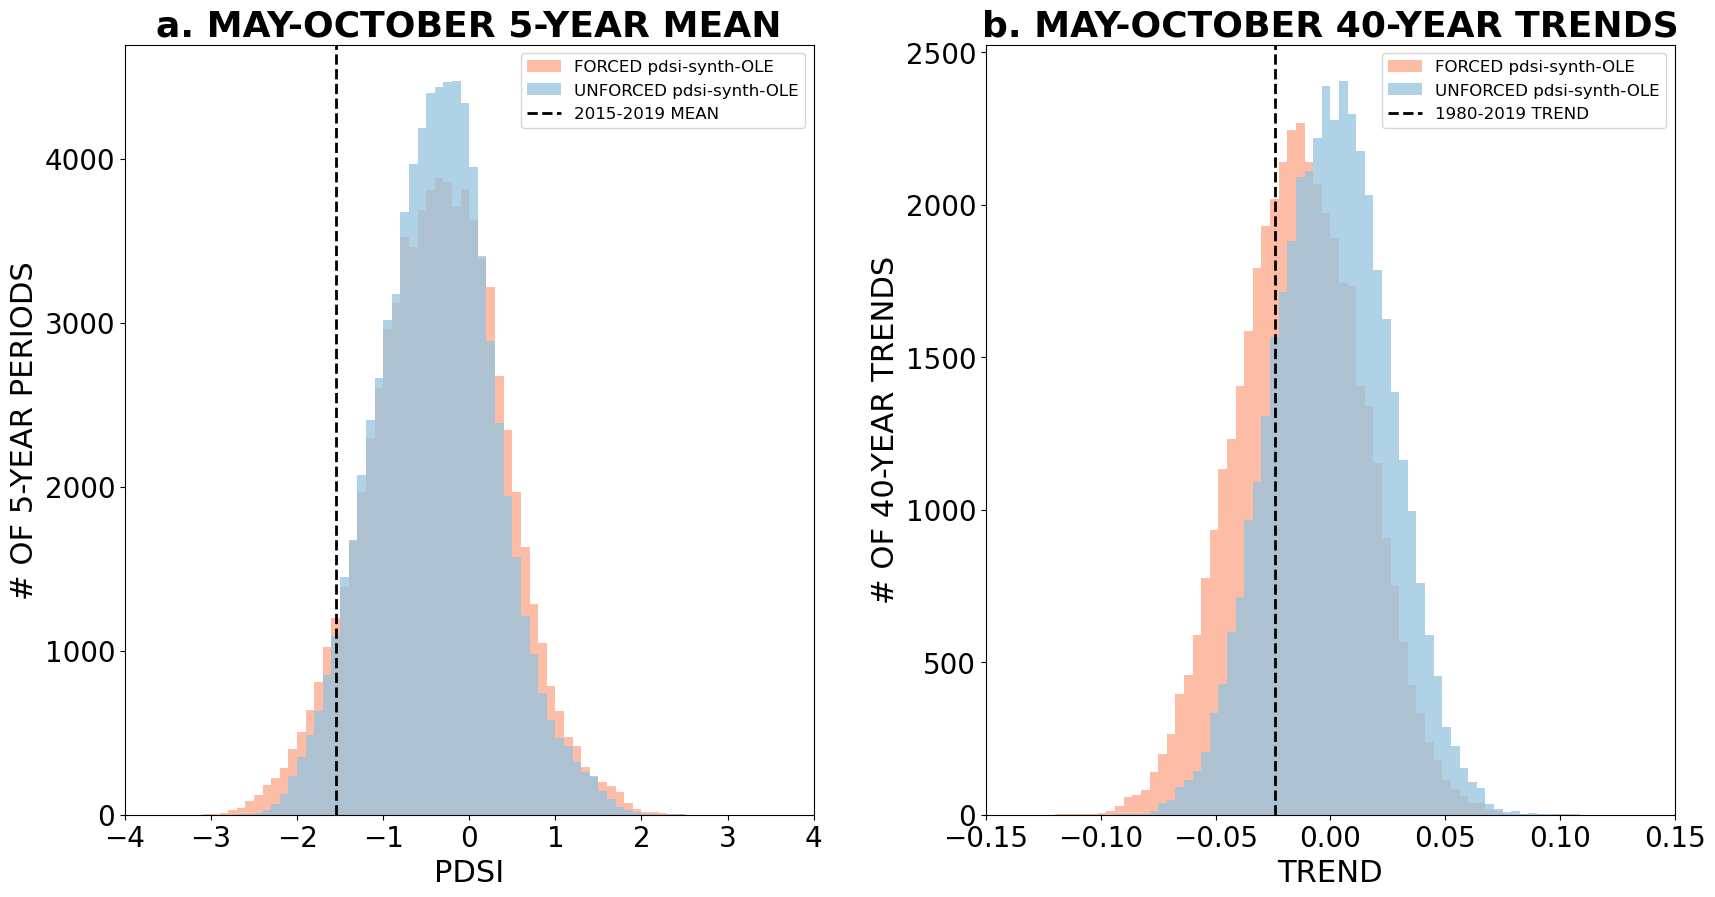

In [22]:
# Plot the histograms together...
# Plot 5 year mean and trends of GS and JA
cmap = mpl.colormaps['Blues']
cmap2 = mpl.colormaps['Reds']
rgba_bins = cmap2(0.3)
rgba_bins2 = cmap(0.4)

fig, ((ax1, ax2)) = plt.subplots(1,2,figsize=[20,10])

ax1.hist(memTS_GS_5yr.flatten('F'),bins=np.linspace(-4,4,81), color = rgba_bins, alpha=.8,label='FORCED pdsi-synth-OLE')
ax1.hist(memTS_GS_5yruf.flatten('F'),bins=np.linspace(-4,4,81), color = rgba_bins2, alpha=.75,label = 'UNFORCED pdsi-synth-OLE')
ax1.axvline(reg5mov_GSObs.precip.values[-1],color = 'k',linestyle='--', linewidth = 2, label = '2015-2019 MEAN')
#ax1.text(-20.75, 5325, 'a.',fontsize=22,fontweight='bold')
ax1.set_xlim([-4, 4])
ax1.set_xlabel("PDSI",fontsize=22)
ax1.set_ylabel("# OF 5-YEAR PERIODS",fontsize=22)
ax1.set_title('a. MAY-OCTOBER 5-YEAR MEAN',fontsize=26, fontweight = 'bold')
ax1.tick_params(labelsize=20)
ax1.legend(loc = 'upper right',fontsize=12)

ax2.hist(memTrend_GS.flatten('F'),bins=np.linspace(-0.15,0.15,81), color = rgba_bins, alpha=.8,label='FORCED pdsi-synth-OLE')
ax2.hist(memTrend_GSuf.flatten('F'),bins=np.linspace(-0.15,0.15,81), color = rgba_bins2, alpha=.75,label = 'UNFORCED pdsi-synth-OLE')
ax2.axvline(mkGSout.slope,color = 'k',linestyle='--', linewidth = 2, label = '1980-2019 TREND')
#ax3.text(-11.25, 2900, 'c.',fontsize=22,fontweight='bold')
ax2.set_xlim([-0.15, 0.15])
ax2.set_xlabel("TREND",fontsize=22)
ax2.set_ylabel("# OF 40-YEAR TRENDS",fontsize=22)
ax2.set_title('b. MAY-OCTOBER 40-YEAR TRENDS',fontsize=26, fontweight = 'bold')
ax2.tick_params(labelsize=20)
ax2.legend(loc = 'upper right',fontsize=12)

plt.subplots_adjust(hspace=0.25, wspace=0.25)

plt.show()

fig.savefig('/glade/work/tanderson/DC_Drought/Figures/All5YRMeans_Trends_GS_CLLJV2_pdsi_forced_unforced.svg', format='svg', transparent=True, bbox_inches='tight')


In [24]:
# Stats drought 

# Unforced drought < obs 
GS_5yr_valsOLEuf = memTS_GS_5yruf[4:,:]
pvalGSuf = np.round(np.sum(GS_5yr_valsOLEuf.flatten()<=reg5mov_GSObs.precip.values[-1])/len(GS_5yr_valsOLEuf.flatten()),3)
print(pvalGSuf)

# Forced drought < obs 
GS_5yr_valsOLE = memTS_GS_5yr[4:,:]
pvalGS = np.round(np.sum(GS_5yr_valsOLE.flatten()<=reg5mov_GSObs.precip.values[-1])/len(GS_5yr_valsOLE.flatten()),3)
print(pvalGS)

# Number of unforced drought events < obs
sumGSuf = np.sum(GS_5yr_valsOLEuf.flatten()<=reg5mov_GSObs.precip.values[-1])
print(sumGSuf)

# Number of forced drought events < obs
sumGS = np.sum(GS_5yr_valsOLE.flatten()<=reg5mov_GSObs.precip.values[-1])
print(sumGS) 

0.045
0.066
3404
5001


In [25]:
# Stats trends

# Percentile forced
pvalGS = np.round(np.sum(memTrend_GS.flatten()<=mkGSout.slope)/len(memTrend_GS.flatten()),3)
print(pvalGS)

# Number of unforced trends < Obs
sumGSnoF = np.sum(memTrend_GSuf.flatten()<=mkGSout.slope)
print(sumGSnoF)

# Number of forced trends < Obs
sumGS = np.sum(memTrend_GS.flatten()<=mkGSout.slope)
print(sumGS)

# Ratio
print(sumGS/sumGSnoF)


0.345
6906
14138
2.0472053286996816
